In [1]:
import numpy as np
import pandas as pd
import json
import codecs
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib as m
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

#Yenny's dups file
json_file = "/Users/kimia/Desktop/Work5/duplicates_batch_2018-05-18.json"
df = pd.read_json(json_file, lines=True)
dfsub = json_normalize(df.submission)

#everything but payload ('twas messy, so I split it then merge)
metadf = dfsub[[ 'task_id', 'updated_at', 'user_id', 'created_at', 'id']]

dfsub = pd.DataFrame(dict(df.submission[0:])).T
dfpayloads = pd.DataFrame()

# I know this isn't efficient. But it helps split out the payloads (multiple per task_id). 
for i in range(dfsub.shape[0]):
    f = pd.DataFrame(dfsub.payload[i]).T
    f['id'] = dfsub.id[i]
    f['task_id'] = dfsub.task_id[i]
    f['user_id'] = dfsub.user_id[i]
    f['created_at'] = dfsub.created_at[i]
    f['updated_at'] = dfsub.updated_at[i]
    dfpayloads = pd.concat([dfpayloads, f])
    
dfpayloads = dfpayloads.reset_index()
dfpayloads = dfpayloads.rename(index=str, columns={"index": "payload"})
dfpayloads['count'] = 1 # this is to signify one input per user
#dfpayloads.to_csv('dfpayloads.csv')
dfpayloads['unique'] = (dfpayloads.task_id).apply(lambda x: str(x)) + (dfpayloads.payload).apply(lambda x: str(x))


In [107]:

taskusdf = pd.read_csv('/Users/kimia/Downloads/Karen.txt', sep=',')[3:]
#['Id', 'Email', 'First'  ,'Last' ,'Created' ,'Updated', 'Hire Date']
taskusdf = taskusdf[['Unnamed: 0', 'Unnamed: 3','Unnamed: 6' ]]

taskusdf['hire'] = pd.to_datetime(taskusdf['Unnamed: 6'],  errors = 'coerce')

taskusdf['today'] = pd.to_datetime('today')
taskusdf['totaltime'] = taskusdf['today'] -taskusdf['hire']
taskusdf["user_id"] = taskusdf["Unnamed: 0"]
taskusdf["user_id"] = taskusdf["user_id"].apply(lambda x: int(x))
taskusdf['timeclean'] = taskusdf['totaltime'].apply(lambda x: int(str(x)[0:3]))


In [108]:

df = dfpayloads 
df = pd.merge(df, taskusdf, on='user_id', how = 'left')


In [21]:
df['LastName'] = df['Unnamed: 3']
countdf = df.groupby(['user_id', 'LastName']).sum()['count'].sort_values().to_frame(name = 'count').reset_index()
del countdf['user_id']



LastName  count
0      Garciso    522
1      Pascual   4264
2       Ropeta   4771
3       Glomar   5559
4     Cruspero   5618
5     Prudente   5775
6       Abeabe   5952
7     Martinez   5967
8      Remulla   5997
9        Guieb   6027
10       Obina   6031
11      Calibo   6581
12   Penecilla   6862
13      Borres   6866
14  Sooksingha   7008
15          Te   7368
16      Lozano   7571
17  Camantigue   7582
18       Taala   7648
19    Dangalan   7655
20    Olivares   7671
21       Reyes   7686
22    Lagumbay   7729
23   Hernandez   7823
24       Camet   7869
25   Dela Rosa   8133

In [51]:
colors =  (2 * np.pi * np.random.rand(26))/10
len(colors)
len(countdf['count'])


26

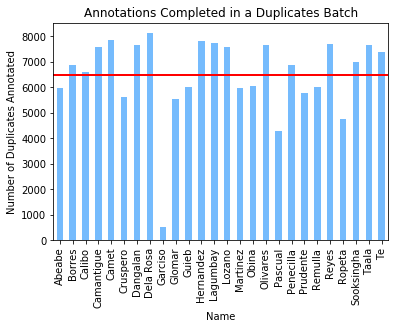

"plt.figure(figsize=(10,5))\nplt.hist(samps_normprop_pos_thinned,bins=100, alpha=0.4, label=u'MCMC distribution (Normal Proposal)', normed=True) \nplt.plot(xxx, f_1(xxx), 'r', label='actual f(x)')\nplt.legend()"

In [53]:

countdf.groupby('LastName').sum()['count'].plot(kind='bar', color = 'xkcd:sky blue')# xlabel="X-axis label", ylabel="y-axix label")
plt.title('Annotations Completed in a Duplicates Batch')
plt.xlabel('Name')
plt.ylabel('Number of Duplicates Annotated')
plt.axhline(countdf['count'].mean(), color='red', linewidth=2)
plt.show()

"""plt.figure(figsize=(10,5))
plt.hist(samps_normprop_pos_thinned,bins=100, alpha=0.4, label=u'MCMC distribution (Normal Proposal)', normed=True) 
plt.plot(xxx, f_1(xxx), 'r', label='actual f(x)')
plt.legend()"""

0.00041715085962873574

In [86]:
## consensus

lowagreement = dfpayloads.groupby(['unique', 'annotation']).size().to_frame(name = 'count').reset_index()
fullagreement = lowagreement[lowagreement['count']>4] ## only 14 are consensus at 4 -- .0002%
lowagreement = lowagreement[lowagreement['count']<5]
print("no consensus:")
print((lowagreement.groupby(['unique']).count()).shape[0]/ (((dfpayloads.groupby(['unique']).count())).shape[0]))
print("consensus:")
print((fullagreement.groupby(['unique']).count()).shape[0]/ (((dfpayloads.groupby(['unique']).count())).shape[0]))


no consensus:
0.08938946992044337
consensus:
0.911564017758708


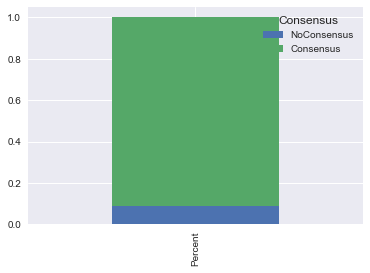

In [104]:
df = pd.DataFrame(columns=["Consensus","Percent", ], 
                  data=[["NoConsensus",0.08938946992044337,],
                   ["Consensus",0.911564017758708,]])
#palette=sns.color_palette("GnBu", 10) 
import seaborn as sns
sns.set()
df.set_index('Consensus').T.plot(kind='bar', stacked=True )



In [ ]:
## time
df['startdate'] = (df.created_at).apply(lambda x: str(pd.to_datetime(x))[0:11])
df['enddate'] = (df.updated_at).apply(lambda x: str(pd.to_datetime(x))[0:11])
np.sum(df['enddate'][0:5] != df['startdate'][0:5])
## everyone does it in one day

df['starttime'] = (df.created_at).apply(lambda x: (pd.to_datetime(str(x))))
df['endtime'] = (df.updated_at).apply(lambda x: (pd.to_datetime(str(x))))
df['totaltime'] = (df['endtime'] - df['starttime'] )

In [112]:
print("The median amount of time taken per task id is %s"% (df['totaltime'].median()) )
print("The 25th quantile of time taken per task id is %s"% (df['totaltime'].quantile(0.25)) )
print("The 75th quantile of time taken per task id is %s"% (df['totaltime'].quantile(0.75)) )
print("The max amount of time taken per task id is %s"% (df['totaltime'].max()) )
print("The min amount of time taken per task id is %s"% (df['totaltime'].min()) )

The median amount of time taken per task id is 0 days 00:02:17.946000
The 25th quantile of time taken per task id is 0 days 00:01:09.153000
The 75th quantile of time taken per task id is 0 days 00:05:29.377000
The max amount of time taken per task id is 11 days 01:29:57.246000
The min amount of time taken per task id is 0 days 00:00:14.460000


In [113]:
def consensus(df, column):
    lowagreement = df.groupby([ 'unique', str(column)]).size().to_frame(name = 'count').reset_index()
    agree5 = lowagreement[lowagreement['count'] >4]
    perc5 = (len(agree5['unique'].unique())/len(lowagreement['unique'].unique()))
    accuracy = ({str(column):perc5})
    return accuracy  

In [114]:
consensus(df, 'annotation')

{'annotation': 0.911564017758708}